# Overview

In this tutorial we will introduce both Google Colab and the TensorFlow 2 / Keras API, including demonstration of basic concepts related to statistical modeling and machine learning. An overview of topics covered in this tutorial include:

**Google Colab**

* Jupyter notebooks
* environment setup

**TensorFlow 2 / Keras API**

* TensorFlow graphs
* creating models
* creating optimizers
* creating loss functions
* model fitting

This tutorial is part of the class **Introduction to Deep Learning for Medical Imaging** at University of California Irvine (CS190); more information can be found: https://github.com/peterchang77/dl_tutor/tree/master/cs190.

# Google Colab

The following lines of code will configure your Google Colab environment for this tutorial.

### Enable GPU runtime

Use the following instructions to switch the default Colab instance into a GPU-enabled runtime:

```
Runtime > Change runtime type > Hardware accelerator > GPU
```

### Jupyter

A Jupyter notebook is composed of blocks of `Markdown` documentation or code referenced as cells. Each cell can be individually selected by a simple click. As you progress through this notebook, simply select a code-containing cell and click the `Run` button on the top toolbar (or alternatively `shift` + `[Enter]`) to execute that particular line or block of code. The `In [ ]` header to the left of each cell will change status to `In [*]` while a line or block of code is executing and then to a number indicating a line or block of executed code if successful.

# TensorFlow and Keras

TensorFlow is a free and open-source software library developed by the Google Brain team for dataflow and differentiable programming
across a range of tasks. It is a symbolic math library, and is most popularly used for machine learning applications such as neural networks. In November 2019, the first stable release of the verson 2.0 library was made available, with significant changes including:

* formal integration of the high-level Keras API for easy model building
* `eager execution` of code, eliminating the need to manually compile man abstract syntax tree using a `session.run()` call
* improved support for model deployment in production on any platform
* improved support for distributed machine learning paradigms

More information highlighting the key improvements can be found here: https://www.tensorflow.org/guide/effective_tf2

## Import

In this tutorial we will use the following Numpy and TensorFlow library components:

In [44]:
import os, numpy as np
from tensorflow import losses, optimizers
from tensorflow.keras import Input, Model, models, layers

## Machine learning 

Machine learning models are **mapping functions** that learn to predict target output(s) based on provided input(s). Inputs may consist of a number of **features** derived from raw data (traditional machine learning models) or simply the **raw data** itself (neural networks). 

A machine learning model is defined by its **parameters**, numeric variables that are applied via **operations** on the algorithm inputs to yield desired outputs. Note that this defintion of learning is broad; in fact all conventional statistical models are systems with *learnable* parameters.  

Consider a simple linear regression model:

```
y = m * x + b
```

As per above, this model meets all key specifications of a learnable system:

* input: `x`
* output: `y`
* parameters: `m` and `b`

Indeed, through repeated exposure to data samples, optimal values for `m` and `b` can be learned such that the target output `y` can be reliably predicted from any given input `x`.

## TensorFlow graphs

To implement a model with TensorFlow, one must reformulate an algorithm into a computational graph: a series of **operations** that define use of **parameters** to map provided input(s) to target output(s). 

### Inputs 

To begin, we need to first define one or several TensorFlow / Keras *inputs* which may be considered *entry-points* into the symbolic graph. All *inputs* are defined using the `Input(...)` class by specifying a tensor `shape` and, optionally, a tensor `dtype`. Let us start by defining a single-element input `x`:

In [45]:
# --- Define an input
x = Input(shape=(1,))

In [46]:
x.shape

TensorShape([None, 1])

Eventually we will need to create an appropriate entry-point for our target variable `y` for training, but let us move on with defining our linear regression model first.

### Operations

Now that we have defined our first `Input` tensor object, we need to apply a mathematical operation to the tensor using a `layers.*` object. First we define the `layers.*` object, and subsequently we pass our `Input` tensor into the operation (as a formal Python `__call__` method) to yield a new intermediate tensor.

In the above simple linear regression model, the multiplication (`m`) and addition (`b`) steps are combined into a single operation known as a **linear transformation**. In the context of neural networks, this operation is also synonmous with the term **densely-connected layer**. To define a linear transformation, use the `layers.Dense(...)` object with a single argument specifying the dimensionality of the desired output. In our example, we are transforming a (single-element) input `x` into another single-element output `y`, and thus we use the value `1` in the `layers.Dense(1)` operation.  

In [47]:
# --- Define a linear transform operation
op = layers.Dense(1)      #1 is the number of ouputs i want after dense operation (denser operation is linear transformation aka mat mul)

# --- Apply linear transform
y = op(x)

In [48]:
y.shape

TensorShape([None, 1])

### Dense layers

Let us examine the `layers.Dense(...)` operation more closely. In the context of neural networks, a **dense** layer refers to a simple matrix multiply operation (or dot product for vectors). Recall that matrices are defined by shape (`row`, `colummns`). Specifically:

```
Let:

X = 1 x N matrix = [a, b, c, d, e...]

M = N x 1 matrix = [[A],
                    [B],
                    [C],
                    [D],
                    [E],
                    ...
                    ]
```

Also recall that when multiplying two matrices, the rows of first matrix are multiplied (and summed) against the columns of the second matrix.

```
Assuming:

X = 1 x N matrix
M = N x 1 matrix

Then:

X x M = ...

= [[a, b, c, d, e...]] x [[A], = a * A + b * B + c * C + d * D + e * E ...
                          [B],
                          [C],
                          [D],
                          [E],
                          ...
                          ]
```

In [49]:
# --- Example with NumPy
x = np.array([1, 2, 3, 4, 5]).reshape(1, 5)
m = np.array([1, 2, 3, 4, 5]).reshape(5, 1)

# --- Matrix multiply or "dense" operation
np.matmul(x, m)

array([[55]])

In addition to the matrix multiplication defined above, a **dense** operation may also include a **bias** addition term which is simply a constant that is added to the matrix multipy operation. In other words:

```
Let:

X = 1 x N matrix (per above)
M = N x 1 matrix (per above)
b = constant

Then: 

A "dense" operation = X x M + b
```

In [50]:
# --- Example with NumPy
x = np.array([1, 2, 3, 4, 5]).reshape(1, 5)
m = np.array([1, 2, 3, 4, 5]).reshape(5, 1)
b = 5

# --- Matrix multiply or "dense" operation with bias
np.matmul(x, m) + b

array([[60]])

Based on this discussion, the simple linear regression model in our example can be in fact be defined using a **dense** layer with a single-element `m`, `x` and `y` terms.

### Parameters

Let move from Numpy back into TensorFlow / Keras by redefining our simple linear regression model:

In [51]:
# --- Define lineaer regression model
x = Input(shape=(1,))
op = layers.Dense(1)
y = op(x)

In the above model it is clear where `x` and `y` are defined, but where are the parameters `m` and `b`? The answer is that in TensorFlow, only intermediate `Tensors` are explicitly defined. By contrast parameters are maintained (and updated) implicitly by the TensorFlow library upon definition of operation `layers`. In other words, `m` and `b` in our model are created automatically by TensorFlow as soon as the operation (`op`) object recieves its input `Tensor` object. Once instantiated both `m` and `b` are stored in the `op` object, and may be retrieved with the `get_weights(...`) method:

In [52]:
# --- See parameters
m, b = op.get_weights()
print(m)
print(b)

[[0.04551733]]
[0.]


By default in TensorFlow, multiplication parameters are set to random values (chosen via the `Glorot` intialization scheme) whereas addition parameters are set to zero. 

## Creating Models

Now that we have defined our graph, we can create a TensorFlow `Model()` object. Doing so requires passing only the model `inputs` and `outputs` into the `Model(...)` class. Upon initialization, all other intermediate tensors between the `inputs` and `outputs` layers are organized in a formal graph structure and maintained by the TensorFlow library.

In [53]:
# --- Create model by passing input(s) and output(s)
backbone = Model(inputs=x, outputs=y)

In our simple graph, a single `Model(...)` can be easily defined to encapsulate all of our model operations. However, in more complex graphs, it may be useful to independently define submodels (each instantiated with a `Model(...)` object) before combining into one large `Model(...)` object. In these more complicated graph definitions, it is important to use descriptive variable names, however the default term `backbone` is often used in more simple architectures. 

To pass an arbitrary value (in the form of a NumPy array) into the model, use the `backbone.predict(...)` function:

In [54]:
# --- Pass an input into the model
backbone.predict(np.array([1]))

array([[0.04551733]], dtype=float32)

How do we replicate this operation using the `m` and `b` NumPy arrays retrieved from above?

In [55]:
# --- Equivalent NumPy operation
m*1+b

array([[0.04551733]], dtype=float32)

For complex models, it may be useful to visualize a summary of all intermediate operations:

In [56]:
# --- Print summary of model architecture
backbone.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 2         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


### Tensor Shapes

What are the shapes of the `x` and `y` Tensors?

In [57]:
# --- Print tensor shapes
print(x.shape)
print(y.shape)

(None, 1)
(None, 1)


Notice that both `x` and `y` tensors contains two dimensions, even though our linear operation is defined for single-element inputs and outputs. In TensorFlow / keras, this additional dimension along axis 0 is designed to accomodate a *batch* of data e.g., instead of applying the linear operation to a single data point, the model is capable of simultaneously applying the same linear operation to many data points. The `None` shape specifically indicates that the first dimension of the `x` and `y` tensors can be **anything** (>= 1). In other words, if I have 10 observations then the shape of the `x` matrix will be `(10, 1)`, which when multiplied by a `(1, 1)` `m` matrix (+ the `b` bias term) will yield a `(10, 1)` output `y` matrix. 

## Endpoint Layer Pattern 

There are many ways to train a model using the TensorFlow / Keras API. The most common (and easiest to use) methods assume a single (or few) model inputs and a single (or few) model outputs, and furthermore limit the loss function to standard strategies predefined in the TensorFlow library. In medical imaging and healthcare applications however, it is quite common to customize and/or modify loss functions with multiple model inputs, outputs and/or intermediate tensors.

To accomodate this complexity, this curriculum used the *endpoint layer* pattern of design. In this strategy, the base `backbone` model architecture is wrapped in a second model with additional layer(s) that define optimization behavior including loss function derivations. To do so, the following steps are required:

1. Define a *wrapper* `Model(...)` that encapsulates our `backbone` model
2. Define loss tensors (and add to the model)
3. Define compile parameters including optimization strategy

Let us look at each of these steps in further detail.

### Inputs

As before, we start by defining all `inputs` into our new *wrapper* model. In the first model, we only defined a single `x` input because the `backbone` base model is designed to accept any input value(s) and make predictions without requiring a target `y`. In our second *wrapper* model, specifically designed to facilitate model training, we additionally need an `Input` object for the target `y` so that we can calculate a loss value and improve our model performance through optimization. 

In [58]:
inputs = {
    'x': Input(shape=(1,), name='x'),
    'y': Input(shape=(1,), name='y')}

Using this `inputs` Python dictionary, let us first redefine the simple linear regression model. Importantly, as opposed to manually defining new layer operations using `layers.Dense(...)` as above, we will **reuse** the `backbone` object that we already defined. Doing so means that our new *wrapper* model is explicitly derived from the `backbone`. Any updates applied to our new *wrapper* model are propogated to the `backbone` model and vice versa. 

In [59]:
# --- Define first step of new wrapper model
y_pred = backbone(inputs['x'])

### Loss

A loss function simply represents a formula that the machine can use to provide feedback regarding the quality of its current set of parameters. In other words, given paired data in the form of `inputs['x']` and target outcomes in `inputs['y']`, as well as model prediction `y_pred`, how does one quantify the *goodness* of the estimated output? Choosing a representative loss function is important as this feedback is used by the machine to improve its parameter values.

In machine learning, any loss formulation can be used to estimate goodness of fit as long as the function is **differentiable**. Many prebuilt loss functions encapsulated by Python classes are availabe for use in the `tf.losses.*` module.

For a linear regression model, performance (e.g. fit) is most commonly evaluated by calculating the *squared distance* between the target output `inputs['y']` and the model prediction `y_pred'`. In other words, if a model predicts `5` when the target output is `2`, then the error is `(5 - 2) ** 2` or `9`. Thus, the parameters `m` and `b` that yield the **least squared error** for all data observations is defined to be optimal. 

In [60]:
# --- Define a MSE loss
loss = (inputs['y'] - y_pred) ** 2

### Training Model

Now let us create the new wrapper model. The inputs are defined above already in our `inputs` Python dictionary. As outputs, let us return both the `y_pred` tensor as well as the `loss`. We will name this new wrapper model `training` because it will be used for training only. 

In [61]:
training = Model(inputs=inputs, outputs={'y_pred': y_pred, 'loss': loss})

In [62]:
training.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 x (InputLayer)                 [(None, 1)]          0           []                               
                                                                                                  
 y (InputLayer)                 [(None, 1)]          0           []                               
                                                                                                  
 model_2 (Functional)           (None, 1)            2           ['x[0][0]']                      
                                                                                                  
 tf.math.subtract_1 (TFOpLambda  (None, 1)           0           ['y[0][0]',                      
 )                                                                'model_2[0][0]']          

Now let's add the `loss` we defined above to the new `training` model:

In [63]:
training.add_loss(loss)

## Compiling a Model

The current model parameters have been initialized to random values. Through exposure to data, the goal is for the model to *learn* optimal parameter values that allow for robust mapping of provided input to target output. To prepare the model for learning, a graph must be **compiled** with a strategy for optimization.

### Defining an optimizer object

An optimizer is a method used by the machine to improve its parameters. By definition, the parameters are updated such that the loss value (calculated by the loss function) decreases. A number of optimization methods have been described and are available through the `tf.optimizers.*` module. Currently, one of the most effective optimizers is the Adam technique which will be used in this tutorial (a good default choice for most tasks). 

In addition to optimizer technique, a learning rate specifying the *degree of change* per update step is required. For the purposes of this tutorial, we will use a default learning rate of `1e-3`.

In [64]:
# --- Define an Adam optimizer
optimizer = optimizers.Adam(learning_rate=1e-3)

### Compiling

Once the model `optimizer` and `loss` objects have been defined, simply pass these objects into the `training.compile(...)` method to prepare for training:

In [65]:
# --- Compile model
training.compile(optimizer=optimizer)

The model is now compiled and ready for training!

# Data

In this tutorial, training data pairs (x, y) will be "simulated". Specifically (x, y) pairs will be drawn using the following equation:

```
y = m * x + b + random
```

Here `m` and `b` represent some ground-truth value for slope and intercept, while `random` represents some random number between `[0, 1]` to simulate noise in the data. For the purposes of demonstration, the values `m = 2` and `b = -1` will be used. 

The following lambda function can be used to create (x, y) training data pairs: 

In [66]:
# --- Define lambda function for random values [-0.5, +0.5]
lo = -0.5
hi = +0.5
rand = lambda shape : np.random.rand(*shape) * (hi - lo) + lo

# --- Define lambda function for linear transform
m = 2
b = -1
f = lambda x : m * x + b + rand(x.shape)

# --- Generate an example (x, y) pair
x = np.random.rand(1)
y = f(x)
print(x, y)

[0.93339571] [0.4344735]


The following lines of code can be used to visualize 100 random samples:

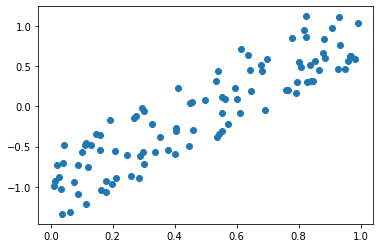

In [67]:
# --- Generate N number examples of data
x = np.random.rand(100)
y = f(x)

# --- Visualize
import pylab
pylab.scatter(x, y)

### Python generators

There are a number of different ways to feed training data into a TensorFlow model. Recall above that a placeholder, the `Input()` object, was defined simply to identify the entrypoint(s) for data into the model. For algorithm training, real data matching the specifications of `Input()` above must be provided. The method of data input used throughout this class will be via **Python generators**.

The Python generator pattern is a unique type of *function* that returns a **lazy generator**, a special iterable that does not store its contents in memory. Instead the contents *yielded* by the generator are created dynamically upon each loop. This is a very efficient way to iterate through datasets, especially as the total size of a dataset becomes large.

The following lines of code wrap up the lambda function above in a Python generator:

In [68]:
def Generator(batch_size=128):
    """
    Method to define a Python generator for training data
    
    """
    # --- Define lambda function for random values [-0.5, +0.5]
    lo = -0.5
    hi = +0.5
    rand = lambda shape : np.random.rand(*shape) * (hi - lo) + lo

    # --- Define lambda function for linear transform
    m = 2
    b = -1
    f = lambda x : m * x + b + rand(x.shape)
    
    while True:
        
        x = np.random.rand(batch_size, 1) 
        y = f(x)
        
        yield {'x': x, 'y': y}

Note that the Generator function recieves a single argument named `batch_size`; this variable represents the total number of training examples that will be generated during each loop. In addition, notice that the shape of both `x` and `y` are in fact `(batch_size, 1)`; this is defined to conform the `Input(...)` variable defined above:

In [69]:
# --- Recall model input shape
inputs['x'].shape

TensorShape([None, 1])

In [70]:
inputs['y'].shape

TensorShape([None, 1])

The following lines of code demonstrated basic Generator functionality:

In [71]:
# --- Instantiating the generator object
gen_train = Generator()

In [72]:
# --- Iterating using for loop
for data in gen_train:
    print(data['x'].shape, data['y'].shape)
    break

(128, 1) (128, 1)


In [73]:
# --- Iterating using next(...)
data = next(gen_train)

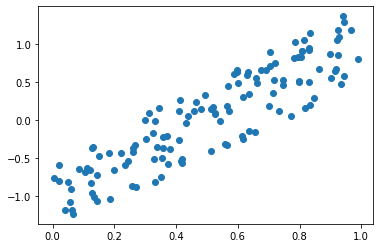

In [74]:
# --- Visualizing
pylab.scatter(data['x'], data['y'])

In [ ]:
training.predict(data)

# Model Training

Once the model has been compiled and the data prepared (via a generator), training can be invoked using the `training.fit(...)` method. The only parameters that need to be set relate to the number of total training iterations (total number of steps = `steps_per_epoch` x `epochs`). 

In [76]:
training.fit(
    x=gen_train, 
    steps_per_epoch=500, 
    epochs=10)

Epoch 1/10
500/500 [==============================] - 1s 2ms/step - loss: 0.3299
Epoch 2/10
500/500 [==============================] - 1s 2ms/step - loss: 0.2229
Epoch 3/10
500/500 [==============================] - 1s 2ms/step - loss: 0.1545
Epoch 4/10
500/500 [==============================] - 1s 2ms/step - loss: 0.1159
Epoch 5/10
500/500 [==============================] - 1s 2ms/step - loss: 0.0950
Epoch 6/10
500/500 [==============================] - 1s 2ms/step - loss: 0.0871
Epoch 7/10
500/500 [==============================] - 1s 2ms/step - loss: 0.0841
Epoch 8/10
500/500 [==============================] - 1s 2ms/step - loss: 0.0837
Epoch 9/10
500/500 [==============================] - 1s 2ms/step - loss: 0.0834
Epoch 10/10
500/500 [==============================] - 1s 2ms/step - loss: 0.0829


After the model has converged, what do we expect that the algorithm learned value for `m` should be? How do we check this?

In [77]:
data.keys()

dict_keys(['x', 'y'])

In [78]:
data['x'].shape

(128, 1)

In [79]:
data['y'].shape

(128, 1)

validating that model is doing right

In [80]:
np.mean((training.predict(data)['y_pred'] - data['y']) **2)

0.0830108770100797

In [81]:
np.mean(training.predict(data)['loss'])

0.08301088

In [82]:
#check m and b values and should be close to insantiated m and b value  

## Saving and Loading a Model

After a model has been successfully trained, it can be saved and/or loaded by simply using the `Model.save()` and `models.load_model()` methods. Note that you have the choice to serialize the `backbone` model (e.g., for inference only) and/or the `training` model (e.g., for additional training).   

In [83]:
# --- Serialize a model
fname = './model_tutorial_wk1.hdf5'
backbone.save(fname)

In [84]:
!ls

model_tutorial_wk1.hdf5  sample_data


In [87]:
# --- Load a serialized model
del backbone
backbone = training.load_model(fname, compile=False)

NameError: ignored

# Exercises

The following exercise questions will assist in preparation for this lesson's assignment, to extend our single variable linear model to a multivariate linear regression:

```
y = m0 * x0 + m1 * x1 + m2 * x2 ... + b
```

### Exercise 1

What modifications to the model definition are needed to increase the number of inputs from 1 variable to 5 (e.g. 5-element vector), while keeping the prediction a single output (e.g. `y`)? Does the `shape` in input need to change? Does the argument in `Dense(...)` need to change? Use the following cell to experiment:

In [88]:
# --- Define a new 5-element input model
x = Input(shape=(5,))
op = layers.Dense(1)
y = op(x)

In [89]:
x.shape

TensorShape([None, 5])

In [90]:
y.shape

TensorShape([None, 1])

#### Hints

Use `x.shape` and `y.shape` to check the input and output shapes. Keep in mind that`x.shape` should be `(None, 5`) for a 5-element input and `y.shape` should be `(None, 1)` for a single-element output.

What shape should the weights in `op.get_weights(...)` represent?

In [91]:
# --- Get weights and check shape
w = op.get_weights()
print(w)

[array([[ 0.69722843],
       [-0.73503375],
       [-0.03052807],
       [ 0.29061818],
       [-0.38659167]], dtype=float32), array([0.], dtype=float32)]


### Exercise 2

What modifications to the lambda function are needed to extend the number of inputs from 1 variable to 5? Keep in mind that the following must be true:

* the input `x` is of shape `(None, 5)`
* the output `y` is of shape `(None, 1)` 

Use the following cell to experiment:

In [93]:
# --- Define new 5-element lambda function
m = 2
b = 1
f = lambda x : m * x + b + rand(x.shape)

In [95]:
x = np.random.rand(5)
y = f(x)
print(x, y)

[0.168197   0.60329248 0.65955366 0.09843339 0.95270929] [1.43859674 2.3880352  2.15556669 1.51684334 3.22289985]


#### Hints

Start with an arbitrary `(None, 5)` input `x`, e.g. an array with shape `(2, 5)`. Given that `m` must also have 5 elements, what shape must `m` be in order to properly perform an `np.matmul(...)` operation? Does the order of multiplication matter e.g. `np.matmul(x, m)` vs. `np.matmul(m, x)`?

In [100]:
# --- Define arbitrary x and m
x = np.random.rand(2, 5)
m = np.array([0, 1, 2, 3, 4]).reshape(5)

# --- Multiply together
np.matmul(x, m)

array([5.70225837, 3.40048555])

In [102]:
m.shape

(5,)

Now add a constant to your matrix multiply:

In [103]:
# --- Multiply together + bias
b = -1
np.matmul(x, m) + b

array([4.70225837, 2.40048555])

Now add random offsets to each of your output `y` values. What dimension of random numbers do you need to accomplish this? Note that if you add a **constant** (like the `b` bias term) you will simply be adding the same random value to **all** your `y` values, thus simply shifting your linear curve in the y-direction: 

In [106]:
x.shape

(2, 5)

In [107]:
m.shape

(5,)

In [114]:
# --- Define random number generator
lo = -0.5
hi = +0.5
rand = lambda shape : np.random.rand(*shape) * (hi - lo) + lo
    
# --- Multiply together + bias + random
np.matmul(x, m) + b + rand((5,1))

array([[4.29230807, 1.99053525],
       [4.35695103, 2.05517821],
       [5.01237166, 2.71059883],
       [4.42496219, 2.12318936],
       [4.2178776 , 1.91610477]])